# Astronomy 3350 Final: Quasar Luminosity
### Aiden Zelakiewicz, Rachel Slaybaugh, Kevin Hoy, Simon Filbert, Sebastian Nunez-Ceardi

The main goal here is to obtain the rest spectral flux density and spectral energy distributions of quasars from multiple surveys.
Data from the Sloan Digitial Sky Survey (SDSS), Two Micron All Sky Survey (2MASS), and Wide-field Infrared Survey Explorer (WISE) are used in the data file labeled __qsodata.dat__ (provided by Dr. Terndrup).
This notebook has a heavy dependency on __pandas__, __numpy__, and __matplotlib.pyplot__.
The package __numpy__ could most likely be substituted fot __math__ if the need arises. 

In [1]:
#Importing some packages to be used
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
#Making some plot adjustments
#Styling Credit: Dr. Terndrup

style_revisions = {
 'axes.linewidth':  1.5, 
 'xtick.top' : True,         
 'ytick.right' :  True,
 'xtick.direction' : 'in',    
 'ytick.direction' : 'in', 
 'xtick.major.size' : 11,     
 'ytick.major.size' : 11,
 'xtick.minor.size' : 5.5,    
 'ytick.minor.size' : 5.5,      
 'font.size' : 16,              
 'figure.figsize' : [10, 8],
 'lines.linewidth' : 2.
}

# Update the matplotlib dictionary.
plt.rcParams.update(style_revisions)

__Calculating the Flux Density:__

Here the magnitude and error of each quasar in the various bands (from each survey) is utilized to calculate the $F_\nu$ and its error in Janskys.
The flux is calculated using two different equations, where 2MASS and WISE use one and SDSS uses a seperate one (with erros being calculated using standard error propagation).
The equation SDSS provides to convert from magnitude to frequency flux density has units of what they call "maggies," which can be converted to Janskys using a factor of 3631 Janskys/maggies.
SDSS also requires a correction coefficient for its magnitudes to convert from luptitudes to AB magnitudes (which 2MASS and WISE are automatically in).
$F_\nu$ for SDSS is calculated using:

$$f_{\nu} = 3631 \cdot (2b) \cdot sinh\left[ -\frac{ln(10)}{2.5}(m_{SDSS} + \textrm{correction})-ln(b) \right]$$

where $m_{SDSS}$ is the SDSS magnitude and b is the softening parameter.
WISE and 2MASS can have the flux calculated using

$$f_{\nu} = 10^{-m_{AB}/2.5} \cdot f_0 $$
where $f_0$ is the flux density of a zero magnitude object (zeropoint flux density) and $m_{AB}$ is the AB magnitude.

In [3]:
def mag2flux(mag, err, survey, band):
    """
    Reads in magnitudes & errors from designated survey & filter, returns flux & errors in terms of frequency.
    Magnitudes and errors should be lists or other iterable object.
    Takes surveys and filters as strings
    
    
    Dependencies
    ------------
    numpy
    
    
    Parameters
    ----------
    mag : list
        Magnitudes of objects for a given filter/band from a specific survey.
    err : list
        Errors in the magnitude of objects for a given filter/band from a specific survey.
    survey : str
        The survey which the given filter is from.
        Valid inputs for surveys can be "SDSS", "2MASS", or "WISE"
    band : str
        The filter/band wanted from a specific survey. 
        SDSS filters can be: 'u', 'g', 'r', 'i', or 'z'
        2MASS filters can be: 'J', 'H', or 'K'
        WISE filters can be: 'W1', 'W2', 'W3', 'W4'
    
    
    Returns
    -------
    fluxes : list
        Frequency flux density in terms of Janskys for each quasar in the given band.
    errors : list
        Errors in the frequency flux density in Janskys for each quasar in the given band.
    
    """
    if survey == 'SDSS':
        
        #Define parameters relevant to each filter
        #zeroflux parameters are given but not in use
        if band == 'u':
            b = 1.4E-10
            zeroflux = 24.63
            correction = -0.04
        elif band == 'g':
            b = 0.9E-10
            zeroflux = 25.11
            correction = 0 
        elif band == 'r':
            b = 1.2E-10
            zeroflux = 24.80
            correction = 0
        elif band == 'i':
            b = 1.8E-10
            zeroflux = 24.36
            correction = 0
        elif band == 'z':
            b = 7.4E-10
            zeroflux = 22.83
            correction = 0.02
        else:
            raise Exception("Error: Invalid filter selection")
            
        #need a conversion because maggies are fake and I don't believe in them
        maggy2jansky = 3631
        
        #Calculate flux
        fluxes = [maggy2jansky * (2*b) * np.sinh((np.log(10) * (i + correction) /-2.5) - np.log(b)) for i in mag]
        errors = [abs((np.log(10)/-2.5) * maggy2jansky * (2*b) \
                      * np.cosh((np.log(10) * (i + correction) /-2.5) - np.log(b)) * j) for i,j in zip(mag,err)]
        
        return fluxes, errors
    
    elif survey == '2MASS':
        
        #Define zero points
        if band == 'J':
            zeropoint = 1594
        elif band == 'H':
            zeropoint = 1024
        elif band == 'K':
            zeropoint = 666.7
        else:
            raise Exception("Error: Invalid filter selection")
        
        #Calculate flux in Jansky's
        fluxes = [10**(-i/2.5) * zeropoint for i in mag]
        errors = [np.log(10) * 10**(-i/2.5) * zeropoint * j for i,j in zip(mag, err)]
        return fluxes, errors
    
    elif survey == 'WISE':
        
        #Define zeropoints
        if band == 'W1':
            zeropoint = 309.540
        elif band == 'W2':
            zeropoint = 171.787
        elif band == 'W3':
            zeropoint = 31.674
        elif band == 'W4':
            zeropoint = 8.363
        else:
            raise Exception("Error: Invalid filter selection")
        
        #Calculate flux in Jansky's
        fluxes = [10**(-i/2.5) * zeropoint for i in mag]
        errors = [np.log(10) * 10**(-i/2.5) * zeropoint * j for i,j in zip(mag, err)]
        return fluxes, errors
    else:
        raise Exception("Error: Invalid survey selection")

__Importing the Data and Calculating $F_\nu$__

Here the data file __qsodata.dat__ is imported into the project using pandas to create an easy to manipulate dataframe.
The values of $F_\nu$ and their errors are then calculated using the function created above and put into a new pandas dataframe.

In [4]:
#Opening file using pandas
qsodat = pd.read_csv('qsodata.dat', delimiter='\s+', comment='#')
qsodat.head()

,QSO,rdshft,u,err_u,g,err_g,r,err_r,i,err_i,...,K,err_K,W1,err_W1,W2,err_W2,W3,err_W3,W4,err_W4
0,J083525.98+435211.2,0.568,18.459,0.015,17.602,0.005,17.550,0.006,17.329,0.006,...,15.141,0.123,13.529,0.026,12.366,0.024,9.950,0.054,7.882,0.201
1,J083643.57+072905.7,0.580,17.826,0.012,17.524,0.005,17.711,0.007,17.624,0.007,...,14.602,0.066,13.133,0.024,11.936,0.022,9.041,0.033,6.812,0.079
2,J085053.12+445122.5,0.542,17.973,0.012,17.537,0.005,17.412,0.006,17.223,0.006,...,14.917,0.116,13.295,0.023,12.209,0.023,9.745,0.041,7.908,0.187
3,J085357.88+463350.6,0.549,18.745,0.021,18.270,0.007,18.225,0.007,17.912,0.007,...,15.294,0.146,13.754,0.025,12.879,0.025,10.840,0.087,8.168,0.232
4,J090313.90+312015.4,0.518,18.827,0.022,18.284,0.018,17.985,0.021,17.642,0.016,...,14.752,0.103,12.949,0.024,11.761,0.022,8.901,0.028,6.605,0.070


In [5]:
#Brute force calculating the frequency flux densities (in Janskys) for each band, could have looped them

fluxu, erru = mag2flux(qsodat.u, qsodat.err_u, 'SDSS', 'u')
fluxg, errg = mag2flux(qsodat.g, qsodat.err_g, 'SDSS', 'g')
fluxr, errr = mag2flux(qsodat.r, qsodat.err_r, 'SDSS', 'r')
fluxi, erri = mag2flux(qsodat.i, qsodat.err_i, 'SDSS', 'i')
fluxz, errz = mag2flux(qsodat.z, qsodat.err_z, 'SDSS', 'z')

fluxJ, errJ = mag2flux(qsodat.J, qsodat.err_J, '2MASS', 'J')
fluxH, errH = mag2flux(qsodat.H, qsodat.err_H, '2MASS', 'H')
fluxK, errK = mag2flux(qsodat.K, qsodat.err_K, '2MASS', 'K')

fluxW1, errW1 = mag2flux(qsodat.W1, qsodat.err_W1, 'WISE', 'W1')
fluxW2, errW2 = mag2flux(qsodat.W2, qsodat.err_W2, 'WISE', 'W2')
fluxW3, errW3 = mag2flux(qsodat.W3, qsodat.err_W3, 'WISE', 'W3')
fluxW4, errW4 = mag2flux(qsodat.W4, qsodat.err_W4, 'WISE', 'W4')

In [6]:
#Putting all the fluxes and errors in a dictionary to make a dataframe
d = {'u': fluxu, 'err_u': erru, 
     'g': fluxg, 'err_g': errg, 
     'r': fluxr, 'err_r': errr,
     'i': fluxi, 'err_i': erri,
     'z': fluxz, 'err_z': errz,
     'J': fluxJ, 'err_J': errJ,
     'H': fluxH, 'err_H': errH,
     'K': fluxK, 'err_K': errK,
     'W1': fluxW1, 'err_W1': errW1,
     'W2': fluxW2, 'err_W2': errW2,
     'W3': fluxW3, 'err_W3': errW3,
     'W4': fluxW4, 'err_W4': errW4}

fluxdata = pd.DataFrame(data = d) #The dataframe

In [7]:
#The wavelength associated with each band given by the surveys in microns
effLambdaDict = {
     'u': 0.3543, 
     'g': 0.4770, 
     'r': 0.6231,
     'i': 0.7625,
     'z': 0.9134,
     'J': 1.235,
     'H': 1.662,
     'K': 2.159,
     'W1': 3.368,
     'W2': 4.618,
     'W3': 12.082,
     'W4': 22.194}

__Calculating rest $F_{\lambda}$ and wavelength__

Here is where $F_{\lambda}$ is obtained by using the relationship
$$F_{\lambda}=\frac{c}{\lambda^2} F_{\nu}$$
where c is the speed of light and $\lambda$ is the pre-adjusted wavelength.
The value of $F_{\nu}$ is converted from Janskys to erg s$^{-1}$ cm$^{-2}$ Hz$^{-1}$ by applying a factor of 10^{-23} to it.
We use c in units of angstroms per second and wavelength in angstroms.
This results in $F_{\lambda}$ having units of erg s$^{-1}$ cm$^{-2}$ angstroms$^{-1}$, which is a conventional unit for it.
We then convert $\lambda$ and $F_{\lambda}$ to the rest frame to remove the effects of wavelength dilation.
The conversion for each is:
$$\lambda_{rest} = \lambda \frac{1}{1+z} \hspace{20pt} F_{\lambda,rest} = F_{\lambda} (1+z)$$

In [8]:
#Creating multiple empty data frames rather than adding to a previous one to help automation and organization (trust)

fluxLambda = pd.DataFrame()
fluxLambdaRest = pd.DataFrame()
errflam = pd.DataFrame()
restlambda = pd.DataFrame()

c = 2.998E+18 #speed of light in angstroms per second to make units nice

#list of filters to be used in various "for" loops and other calling conventions
filters = ['u', 'g', 'r', 'i', 'z', 'J', 'H', 'K', 'W1', 'W2', 'W3', 'W4']

#Snipping redshift out to use
red = qsodat['rdshft']

#Following loop calculates the:
#rest wavelength in angstroms
#wavelength flux density in erg s^-1 cm^-2 angstrom^-1

for f in filters:
    
    #Wavelength before correction for given band and converting to angstroms
    wavelength = effLambdaDict[f] * 10**4 
    
    #Calculating F lambda from F nu (and converting F nu from Jansky to erg s^-1 cm^-2 Hz^-1)
    fluxLambda[f] = [c/(wavelength**2) * k * 10**(-23) for k in fluxdata[f]]
    
    #Calculating error in F lambda
    errstr = "err_" + f
    errflam[errstr] = [c/(wavelength**2) * k *10**(-23) for k in fluxdata[errstr]]
    
    #Applying the redshift conversion to obtain rest wavelength
    lambdastr = "rest_" + f
    restlambda[lambdastr] = [wavelength / (1+z) for z in red]
    
    #Applying the redshift adjustment to the flux density
    preFlux = fluxLambda[f]
    fluxLambdaRest[f] = [flx * (1+z) for flx,z in zip(preFlux,red)]


__Plotting__

Now that $F_{\lambda}$ is calculated, the spectral flux density and spectral energy distribution (SED) can be graphed.
The SED is defined by a plot of $\lambda F_{\lambda}$ (with units erg s$^{-1}$ cm$^{-2}$) against wavelength.
The spectral flux density is also plotted against $\lambda$ in angstroms.

In [9]:
#Here the quasars' flux, error and wavelength are organized by quasar
#to easily plot the data by quasar

qsoFWL = pd.DataFrame()

for i in range(len(qsodat['QSO'])):
    index=i
    flx = []
    lmb = []
    err = []
    for f in filters:
        flx.append(fluxLambdaRest[f][index])
        lmb.append(restlambda["rest_"+f][index])
        err.append(errflam['err_'+f][index])
    qsoFWL[str(index)+"F"] = flx
    qsoFWL[str(index)+"WL"] = lmb
    qsoFWL[str(index)+'err'] = err   

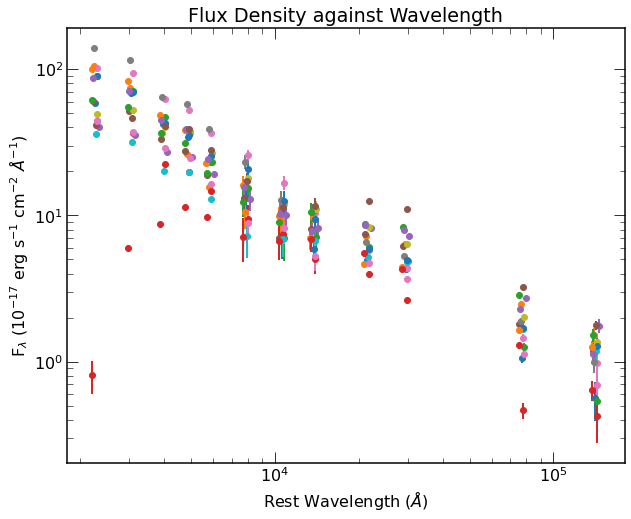

In [10]:
#Creating figure for Flux density vs wavelength
fig, ax = plt.subplots()

#Plotting the flux density
for i in range(len(qsodat.QSO)):
    flx = str(i)+'F'
    lam = str(i)+'WL'
    err = str(i) + 'err'
    ax.errorbar(qsoFWL[lam],qsoFWL[flx]*10**(17) \
                ,fmt='o',yerr = qsoFWL[err]*10**(17))
    
#plot styling
ax.set_xlabel('Rest Wavelength ($\AA$)')
ax.set_ylabel('F$_\lambda$ ($10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
plt.title('Flux Density against Wavelength')
ax.set_yscale('log')
ax.set_xscale('log')

#Code below creates a watermark
#ax.text(0.5, 0.5, 'Preliminary', transform=ax.transAxes,
#        fontsize=100, color='gray', alpha=0.5,
#        ha='center', va='center', rotation='30')
    
plt.show()
#plt.savefig('Flambda.jpg')

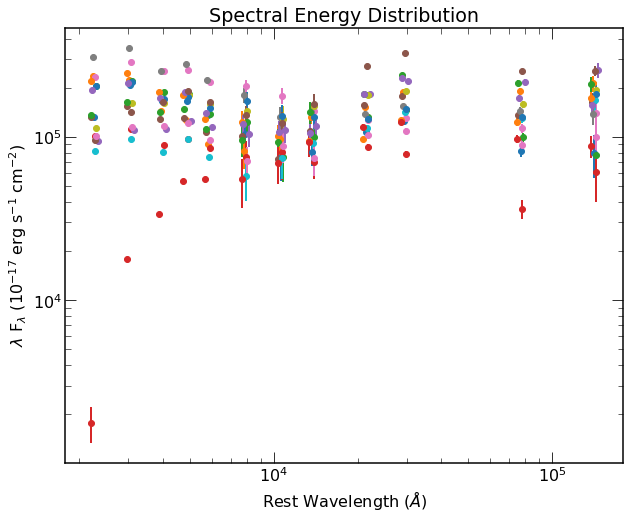

<Figure size 720x576 with 0 Axes>

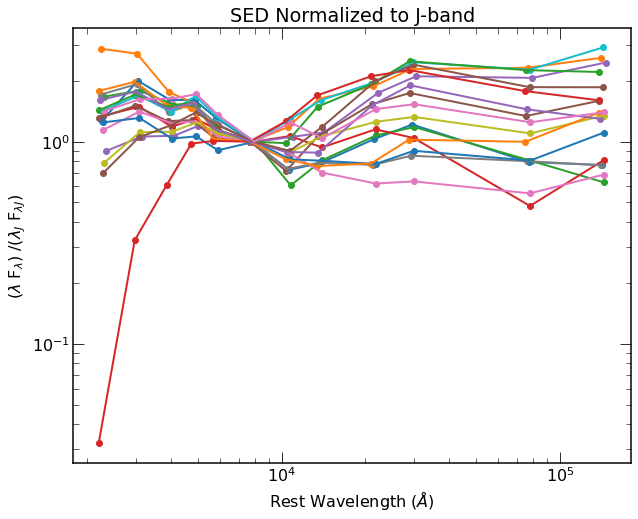

<Figure size 720x576 with 0 Axes>

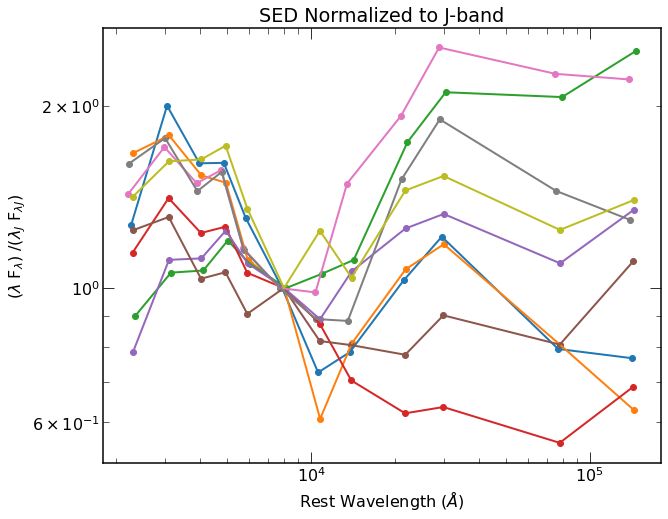

In [11]:
#Creating Spectral Energy Distribution figure
fig, ax = plt.subplots()

#Plotting the 
for i in range(len(qsodat.QSO)):
    flx = str(i)+'F'
    lam = str(i)+'WL'
    err = str(i) + 'err'
    ax.errorbar(qsoFWL[lam],qsoFWL[lam]*qsoFWL[flx]*10**(17) \
                ,fmt='o',yerr = qsoFWL[lam]*qsoFWL[err]*10**(17))
    
#Plot styling
ax.set_xlabel('Rest Wavelength ($\AA$)')
ax.set_ylabel('$\lambda$ F$_\lambda$ ($10^{-17}$ erg s$^{-1}$ cm$^{-2}$)')
ax.set_yscale('log')
ax.set_xscale('log')
plt.title('Spectral Energy Distribution')

#Code below creates a watermark for preliminary results
#ax.text(0.5, 0.5, 'Preliminary', transform=ax.transAxes,
#        fontsize=100, color='gray', alpha=0.5,
#        ha='center', va='center', rotation='30')
    
plt.show()
#plt.savefig('SpectralEnergyDist.jpg')

plt.clf() #Clearing figure information

fig, ax = plt.subplots()

#Plotting the SED normalized to the J-band
for i in range(len(qsodat.QSO)):
    flx = str(i)+'F'
    lam = str(i)+'WL'
    err = str(i) + 'err'
    ax.scatter(qsoFWL[lam],(qsoFWL[lam]*qsoFWL[flx]/(qsoFWL[lam][5]*qsoFWL[flx][5])) \
                ,marker='o')
    ax.plot(qsoFWL[lam],(qsoFWL[lam]*qsoFWL[flx]/(qsoFWL[lam][5]*qsoFWL[flx][5])))
    
#plot styling
ax.set_xlabel('Rest Wavelength ($\AA$)')
ax.set_ylabel('($\lambda$ F$_\lambda$) /($\lambda_J$ F$_{\lambda J}$) ')
plt.title('SED Normalized to J-band')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()
#plt.savefig('NormSED.jpg')

plt.clf() #Clearing figure information

fig, ax = plt.subplots()

#Plotting the same thing as above (normalized SED), but for only half the quasars to make viewing nicer
for i in range(0,len(qsodat.QSO),2):
    flx = str(i)+'F'
    lam = str(i)+'WL'
    err = str(i) + 'err'
    ax.scatter(qsoFWL[lam],(qsoFWL[lam]*qsoFWL[flx]/(qsoFWL[lam][5]*qsoFWL[flx][5])) \
                ,marker='o')
    ax.plot(qsoFWL[lam],(qsoFWL[lam]*qsoFWL[flx]/(qsoFWL[lam][5]*qsoFWL[flx][5])))

#plot styling
ax.set_xlabel('Rest Wavelength ($\AA$)')
ax.set_ylabel('($\lambda$ F$_\lambda$) /($\lambda_J$ F$_{\lambda J}$) ')
plt.title('SED Normalized to J-band')
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

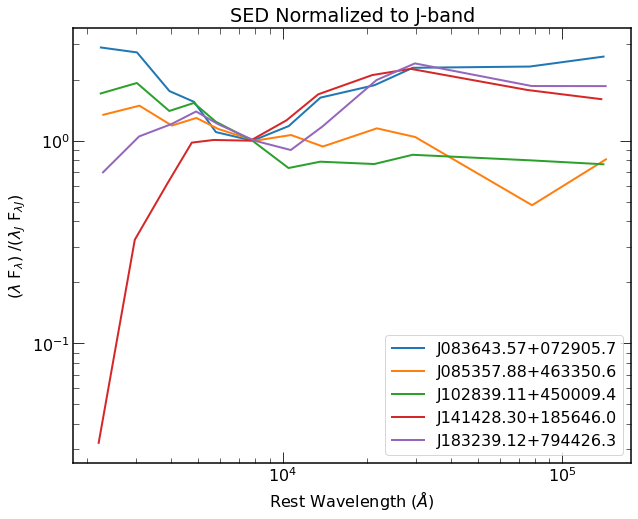

In [12]:
#Here we plot some 'weird' quasar SED's against a fairly normal one.
#The normal SED is the one where i=7 (J102839.11) and is green in the figure.

fig, ax = plt.subplots()

#Plotting the SED normalized to the J-band
for i in [1,3,7,13,15]:
    flx = str(i)+'F'
    lam = str(i)+'WL'
    err = str(i) + 'err'
    ax.plot(qsoFWL[lam],qsoFWL[lam]*qsoFWL[flx]/(qsoFWL[lam][5]*qsoFWL[flx][5]),label=str(qsodat["QSO"][i]))
    
#plot styling
ax.set_xlabel('Rest Wavelength ($\AA$)')
ax.set_ylabel('($\lambda$ F$_\lambda$) /($\lambda_J$ F$_{\lambda J}$) ')
plt.title('SED Normalized to J-band')
ax.set_xscale('log')
ax.set_yscale('log')
plt.legend()
plt.show()

Now we create a function __plotQSO()__ which allows the user to select which quasar they would like to view to create plots of each individually. It will take an input integer which will pull fluxes, wavelengths, and errors to create a spectral flux density and spectral energy distribution for it. An arugment can also be passed as to whether one wants to save the figure as a jpg or just show them both (__plt.show()__ is the default).

In [13]:
def plotQSO(save=False):
    """
    Function to plot the spectral flux density and spectral
    energy distribution of a select quasar denoted by the
    index in which it appears in the pandas array qsoFWL.
    
    
    Dependencies
    ------------
    numpy
    pandas
    matplotlib.pyplot
    
    
    Parameters
    ----------
    save : bool (optional)
        If true, saves both the flux density and SED plot 
        as a jpg. Otherwise the figure is just shown
        regularlly
    
    """
    i = int(input("Enter the number associated with the quasar you want to observe: "))
    
    #Creating the spectral flux density figure
    fig, ax = plt.subplots()
    
    #Plotting from our quasar list
    flx = str(i)+'F'
    lam = str(i)+'WL'
    err = str(i) + 'err'
    ax.errorbar(qsoFWL[lam],qsoFWL[flx]*10**(17) \
                ,fmt='o',yerr = qsoFWL[err]*10**(17))
    ax.plot(qsoFWL[lam],qsoFWL[flx]*10**(17),'b')
           
    ax.set_xlabel('Rest Wavelength ($\AA$)')
    ax.set_ylabel('F$_\lambda$ ($10^{-17}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.title('Spectral Flux Density for '+str(qsodat['QSO'][i]))
    
    if save == True:
        plt.savefig('FLUXofQSO'+str(i)+'.jpg')
    else:
        plt.show()
    
    plt.clf() #Clearing figure information
    
    #Plotting the spectral energy distribution
    
    fig, ax = plt.subplots()
    
    #Naming strings
    flx = str(i)+'F'
    lam = str(i)+'WL'
    err = str(i) + 'err'
    
    
    ax.errorbar(qsoFWL[lam],qsoFWL[lam]*qsoFWL[flx]*10**(17) \
                ,fmt='o',yerr = qsoFWL[lam]*qsoFWL[err]*10**(17))
    ax.plot(qsoFWL[lam],qsoFWL[lam]*qsoFWL[flx]*10**(17),'b')
        
    ax.set_xlabel('Rest Wavelength ($\AA$)')
    ax.set_ylabel('$\lambda$ F$_\lambda$ ($10^{-17}$ erg s$^{-1}$ cm$^{-2}$)')
    ax.set_yscale('log')
    ax.set_xscale('log')
    plt.title('SED of '+ str(qsodat['QSO'][i]))
    
    if save == True:
        plt.savefig('SEDofQSO'+str(i)+'.jpg')
    else:
        plt.show()

Enter the number associated with the quasar you want to observe: 1


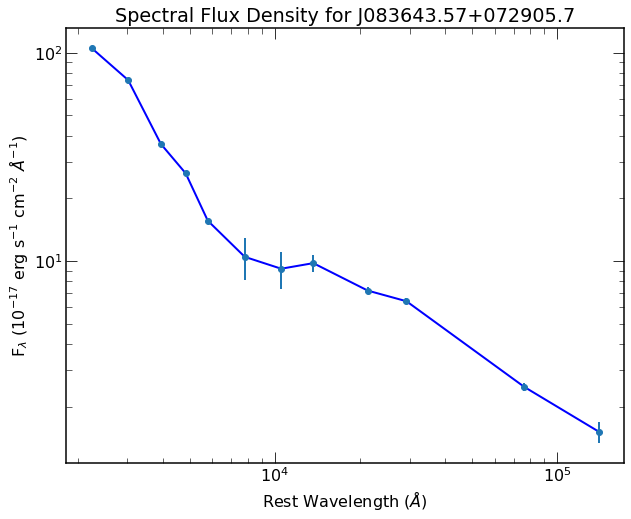

<Figure size 720x576 with 0 Axes>

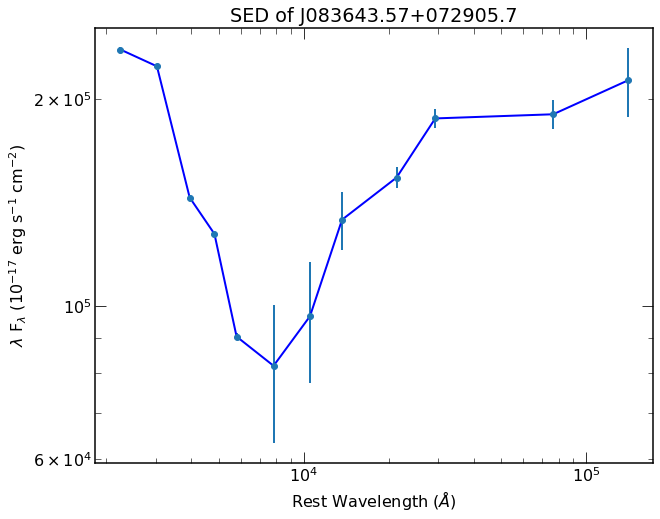

In [14]:
plotQSO()